#### Prepared by: Yerbol Aussat
#### CS-889. University of Waterloo


# K-Curvature Finger Tracking


In [454]:
# Import necessary libraries and helper functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from helpers import imshow

In [455]:
# Method that generates mask that segments out skin regions 
def segment_skin_hsv(img):
    # Convert image to HSV
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # define range of hsv (for skin color)
    min_HSV = np.array([0, 58, 30], dtype = "uint8")
    max_HSV = np.array([33, 255, 255], dtype = "uint8")

    # create a mask and clean it up
    mask = cv2.inRange(hsv, min_HSV, max_HSV)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 5)
    mask = cv2.medianBlur(mask, 5)   
    
    return mask

In [457]:
def getHandContours(mask):
    # Get the contour of the hand and draw it on the original image
    im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Calculate areas
    areas = [cv2.contourArea(cont) for cont in contours]
    
    # Only keep the largest contour
    if len(contours) == 0:
        return
    cnt = contours[np.argmax(areas)]
    return cnt

## Note: CHAIN_APPROX_SIMPLE parameter of findContours method doesn't return uniformly spaced points. Use CHAIN_APPROX_NONE instead.

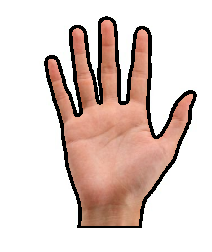

[[[344  43]]

 [[339  44]]]


In [465]:
# Import the original image
img = cv2.imread('palm2.jpg')

mask = segment_skin_hsv(img) # Mask that segments skin regions
cnt = getHandContours(mask) # Hand Contour

# Draw contour
for index in range(len(cnt)):
    cv2.circle(img, tuple(cnt[index][0]), 1, (0, 0, 0), 15)    

imshow(img)

In [469]:
# Import the original image to n points
def getDownsampledContour(img, n):
    mask = segment_skin_hsv(img) # Mask that segments skin regions
    cnt = getHandContours(mask) # Hand Contour 
    interval = len(cnt)/n
    cnt = cnt[0:len(cnt):interval] #downsample to 100 points
    return cnt

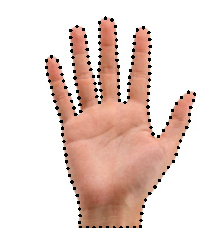

In [472]:
img = cv2.imread('palm2.jpg')
cnt = getDownsampledContour(img, 150)
# Draw contour
for index in range(len(cnt)):
    cv2.circle(img, tuple(cnt[index][0]), 1, (0, 0, 0), 15) 
imshow(img)

## Now we can ready to apply k-Curvature algorithm 
   ###  Take k = 3 and threshold angle = 60

In [487]:
k = 3
thresh_angle = 65

In [488]:
# Helper function to find angle between two vectors
def get_angle(v1, v2):
    v1 = v1 / np.linalg.norm(v1) # unit vector v1
    v2 = v2 / np.linalg.norm(v2) # unit vector v2
    cos_theta = np.dot(v1, v2) 
    return np.arccos(cos_theta)*(180/np.pi)

# Helper function to find distance between two vectors
def dist(v1, v2):
    return np.linalg.norm(np.array(v1)-v2)

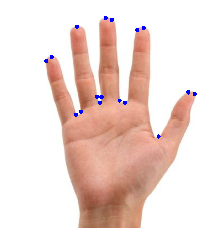

In [489]:
img = cv2.imread('palm2.jpg')
cnt = getDownsampledContour(img, 150)

for j in range(len(cnt)):
        
    # determine points corresponding to indices j-k, j and j+k
    pointJ = cnt[j][0]
    minusK = cnt[(j-k)%len(cnt)][0]
    plusK = cnt[(j+k)%len(cnt)][0]
    
    angle = get_angle(minusK - pointJ, plusK - pointJ)
        
    if angle <= thresh_angle:
        cv2.circle(img, tuple(pointJ), 1, (255, 0, 0), 20)
imshow(img)

# Implement two tweaks:
### 1) To differentiate between the space between fingers and the fingertips find cross product
### 2) Out of neighboring points that satisfy the threshold take the one with the lowest k-curvature 

In [491]:
# # Helper function that updates an array of stored points, corresponding to 
# # valleys or peaks)
# pointDict: {index -> k_curv}

def update(pointDict, j, kCurv):
    
    for i in pointDict:
        
        # if index j is close to one of the stored indices 
        if abs(i-j) <= 3 or abs(i-j) >= len(cnt) - 3:
            
            # if k-curvature of point j is smaller, replace i by it
            if kCurv < pointDict[i]:
                pointDict[j] = kCurv
                del pointDict[i]
            return pointDict                        
    pointDict[j] = kCurv
    return pointDict

In [492]:
img = cv2.imread('palm2.jpg')
cnt = getDownsampledContour(img, 150)

peaks = {} # Array that stores points corresponding to fingertips
valleys = {} # Array that stores points corresponding to spaces

for j in range(len(cnt)):
    
    # determine points corresponding to indices j-k, j and j+k
    jCoord = cnt[j][0]
    minusK = cnt[(j-k)%len(cnt)][0]
    plusK = cnt[(j+k)%len(cnt)][0]
        
    kCurv = get_angle(minusK - jCoord, plusK - jCoord)
    
    if kCurv <= thresh_angle:
                
        orientation = np.cross(minusK - jCoord, plusK - jCoord)
        
        if orientation >= 0:
            peaks = update(peaks, j, kCurv)
        else:
            valleys = update(valleys, j, kCurv)

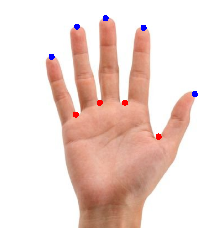

In [493]:
# Draw valleys as red circles
for j in valleys:
    jCoord = cnt[j][0]
    cv2.circle(img, tuple(jCoord), 1, (0, 0, 255), 30)
    
# Draw peaks as blue circles
for j in peaks:
    jCoord = cnt[j][0]
    cv2.circle(img, tuple(jCoord), 1, (255, 0, 0), 30)
imshow(img)

# Use convex hull to get candidate points for k-Curvature test

In [453]:
# Import the original image
img = cv2.imread('palm2.jpg')

mask = segment_skin_hsv(img) # Mask that segments skin regions
cnt = getHandContours(mask) # Hand Contour